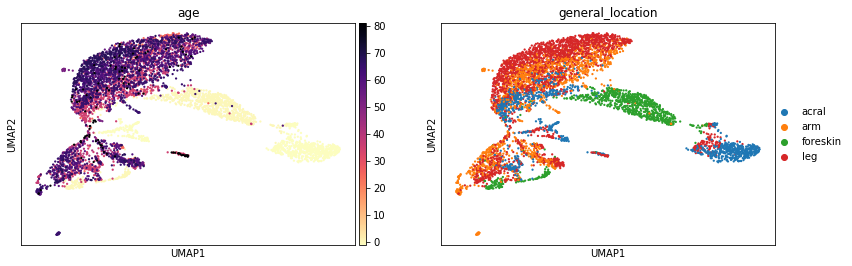

... storing 'noise_group' as categorical


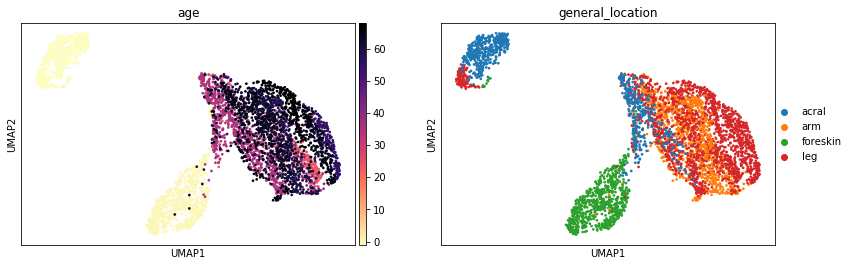

Completed


In [1]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import display, HTML

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT', 'raw_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


In [2]:
%%capture
###############################################
###############################################
# Classify acral vs. cutaneous vs. foreskin cells
# This chunk updates input adata
###############################################
###############################################

patient2feature = {'12WKM01':'0',
                   'A1038LM':'1'}

input_adata = adata_subset2

rank_groupby = 'louvain'
rank_ngenes = 20

###############################################

ranks_dict = {}
for patientOI, value in patient2feature.items():
    exec(f'global adata_{patientOI}')
    input_adata = adata_subset2
    patients = list(set(input_adata.obs.patient))
    type_dict = {'in':[patientOI],
                 'out':[x for x in patients if x != patientOI]}

    classify_type(raw_adata, input_adata, 'patient', type_dict, 'class_3')

    feature_dict = {'class_3':['in']}
    adata_subset3 = subset_adata_v3(raw_adata,feature_dict)
    adata_subset3 = process_adata(adata_subset3)
    pca_adata(adata_subset3, num_pcs=30)
    umap_adata(adata_subset3, res=0.2)
    sc.pl.umap(adata_subset3, color=['louvain','general_location'])
    
    exec(f'adata_{patientOI} = input_adata = adata_subset3')
    ranks_df = simple_rank (input_adata, groupby=rank_groupby, n_genes=rank_ngenes)
    ranks_df['patient'] = patientOI
    ranks_dict[patientOI] = ranks_df

### Need to classify cell type to disambigueate mixed populations in general location
# extract cell id from individual patients with acral
# rely on louvain clustering to annotate cell type

acral_cells_list = []
for key,value in patient2feature.items():
    acral_slice = eval(f'adata_{key}.obs.reset_index().loc[:,["index","louvain"]]')
    acral_slice = acral_slice[acral_slice.louvain == patient2feature[key]]
    acral_cells = acral_slice['index'].values.tolist()
    acral_cells_list= acral_cells_list + acral_cells

# create cell type labels: cut, fsk, acr
adata_subset2.obs['cell_type'] = ['fsk' if x == 'foreskin' else 'cut' for x in adata_subset2.obs.general_location]
adata_subset2.obs['cell_type'] = ['acr' if x in acral_cells_list else y for x,y in zip(adata_subset2.obs.index,
                                                                                       adata_subset2.obs.cell_type)]


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_3' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_3' as categorical


acr
   PC        f1
0   1  0.000000
1   2  0.712788
2   3  0.000000
3   4  0.000000
4   5  0.007812
5   6  0.007782
6   7  0.000000
7   8  0.000000
8   9  0.000000
9  10  0.000000


... storing 'noise_group' as categorical
... storing 'cell_type' as categorical


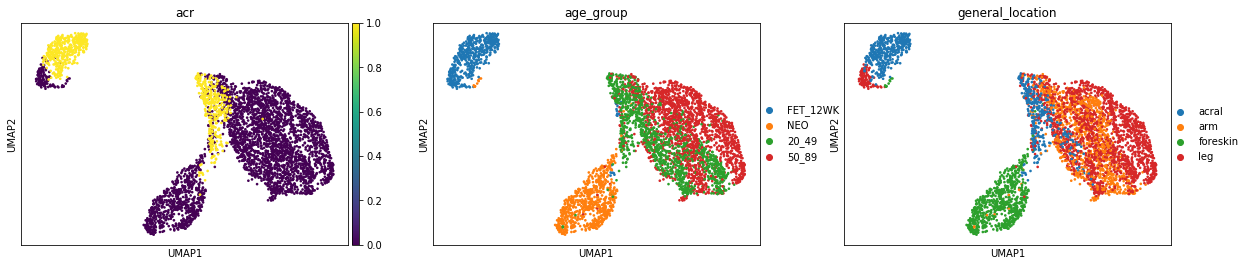

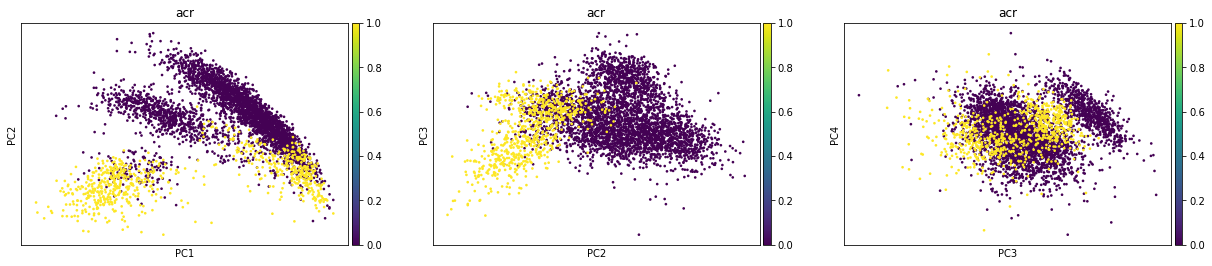

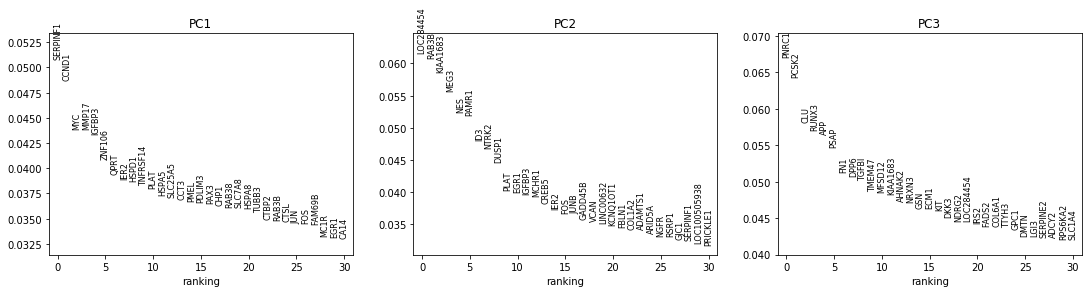

fsk
   PC        f1
0   1  0.088154
1   2  0.000000
2   3  0.812095
3   4  0.250825
4   5  0.000000
5   6  0.000000
6   7  0.000000
7   8  0.000000
8   9  0.000000
9  10  0.008097


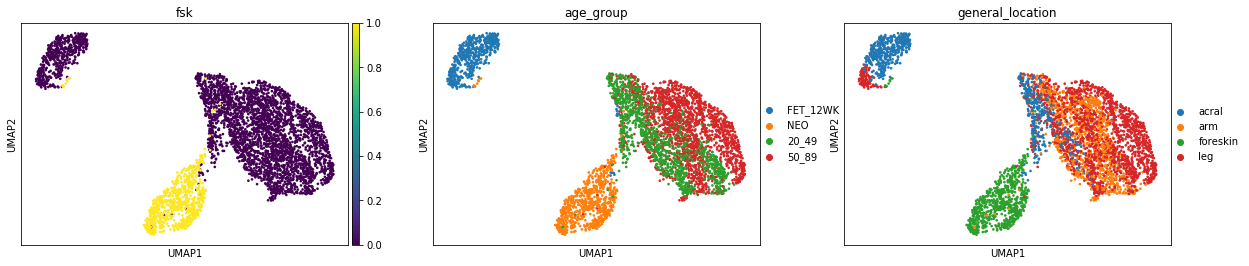

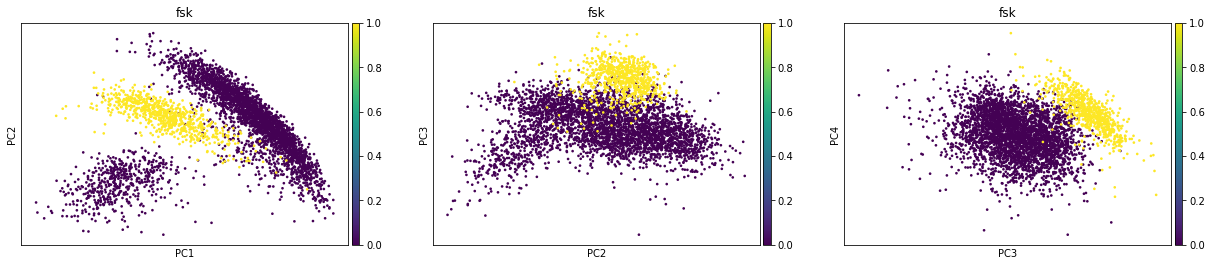

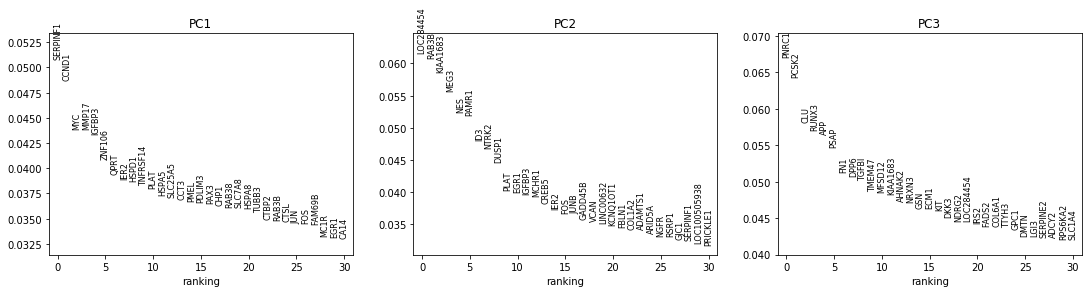

In [3]:
# determine which pc coordinate set best recalls general location label
input_adata = adata_subset2
pca_genes_df = pd.DataFrame()

for groupby in ['acr', 'fsk']:
    print(groupby)
    input_adata.obs[groupby] = [x in [groupby] for x in input_adata.obs['cell_type'].values]

    results_list = []
    cell_list = input_adata.obs_names
    loc_list = input_adata.obs[groupby].values
    for PC in range(input_adata.obsm['X_pca'].shape[1]):
        PC_list = input_adata.obsm['X_pca'][:,PC]

        pred = PC_list # must be continuous
        res = np.array(loc_list) # must be categorical
        pred = pred.reshape(-1,1)
        res = res.reshape(-1,1)

        if len(np.unique(res)) == 1:
            acc = 0
        else:
            X_train, X_test, y_train, y_test = train_test_split(pred,
                                                                res,
                                                                test_size=0.33, 
                                                                random_state=42)
            # accurcy
            clf = LogisticRegression(multi_class='auto')
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc  = f1_score(y_true = y_test, 
                            y_pred = y_pred, 
                            average = 'binary')

            results_list.append(acc)
    print(pd.DataFrame({'PC':[x+1 for x in range(len(results_list))],
                  'f1':results_list}).head(10))

    sc.pl.umap(input_adata, color=[groupby,'age_group','general_location'])
    sc.pl.pca(input_adata, components=['1,2','2,3','3,4'], color=[groupby])
    sc.pl.pca_loadings(input_adata)
    
    # extract gene names from loadings
    ## top10 and bottom10 genes for top10 PCs
    for idx in range(10):
        pc_idx = idx

        pc_genes = (pd.DataFrame({'genes': input_adata.var_names.tolist(),
                                  'loadings': input_adata.varm['PCs'][:,pc_idx]})
                   .sort_values('loadings'))
        pc_genes['pc_idx'] = pc_idx
        pc_genes['idx'] = [x for x in range(len(pc_genes))]
        pc_genes['groupby'] = groupby
        pca_genes_df = pca_genes_df.append(pc_genes.head(10))
        pca_genes_df = pca_genes_df.append(pc_genes.tail(10))
        

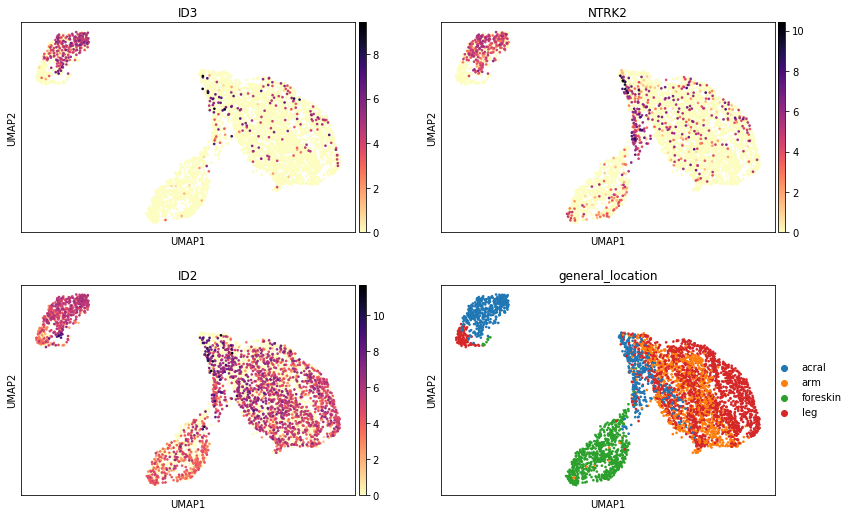

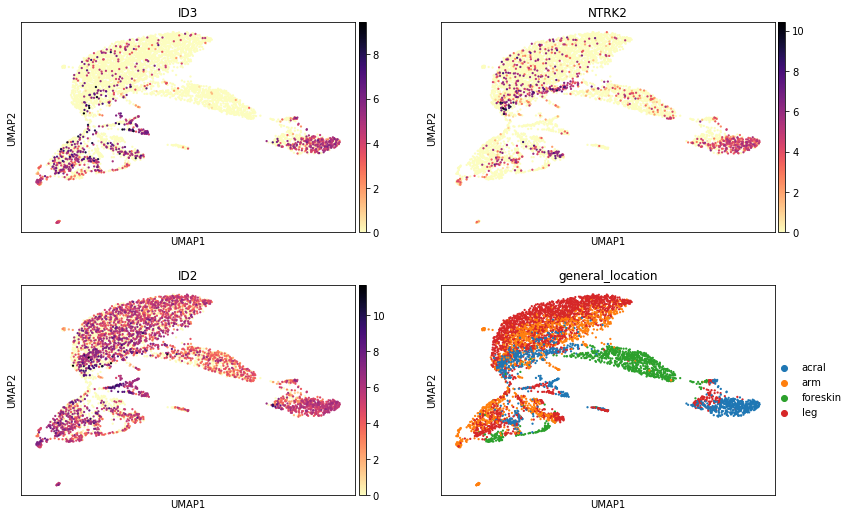

querying 1-3...done.
Finished.
0: ID3
The protein encoded by this gene is a helix-loop-helix (HLH) protein that can form heterodimers with other HLH proteins. However, the encoded protein lacks a basic DNA-binding domain and therefore inhibits the DNA binding of any HLH protein with which it interacts. [provided by RefSeq, Aug 2011].
1: NTRK2
This gene encodes a member of the neurotrophic tyrosine receptor kinase (NTRK) family. This kinase is a membrane-bound receptor that, upon neurotrophin binding, phosphorylates itself and members of the MAPK pathway. Signalling through this kinase leads to cell differentiation. Mutations in this gene have been associated with obesity and mood disorders. Alternative splicing results in multiple transcript variants. [provided by RefSeq, May 2014].
2: ID2
The protein encoded by this gene belongs to the inhibitor of DNA binding family, members of which are transcriptional regulators that contain a helix-loop-helix (HLH) domain but not a basic domain. M

In [4]:
###############################################
###############################################
# Display summary of DE genes found in all samples
# This chuck displays MEL and all-cells UMAPS and gene annotations
###############################################
###############################################

# Specify patients and feature group
patient2feature = {'12WKM01':'0',
                   'A1038LM':'1'}

###############################################

full_list = []
for key,value in patient2feature.items():
    list_iter = list(set(ranks_dict[key][value].values.tolist()))
    full_list = full_list + list_iter

union_df = pd.DataFrame({'genes':full_list})['genes'].value_counts()
genes = union_df[union_df > 1].index.tolist()
sc.pl.umap(adata_subset2, color=genes+['general_location'], ncols = 2, cmap='magma_r')
sc.pl.umap(full_adata, color=genes+['general_location'], ncols = 2, cmap='magma_r')
out = symbol2field(genes)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ''
output = [print(x) for x in full_report if search_term in x]

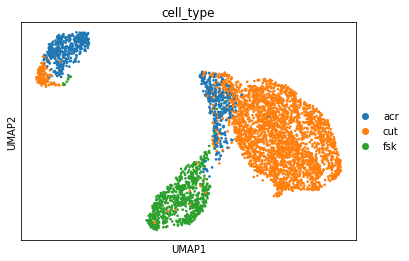

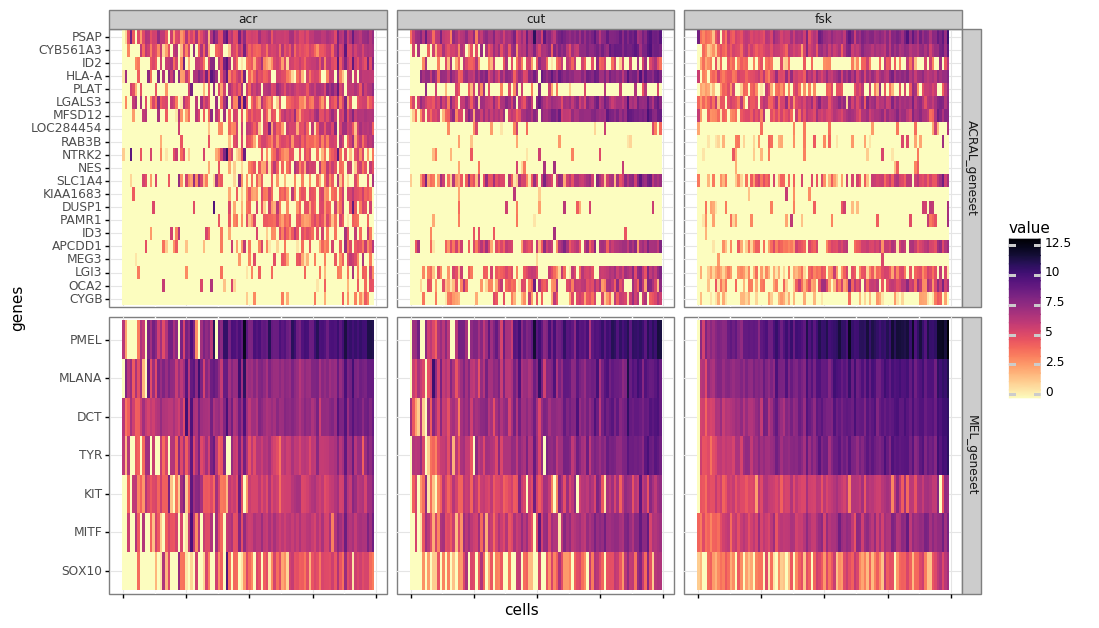

<ggplot: (8769476804728)>


In [5]:
# heat map of Acral vs rest
input_adata = adata_subset2
sc.pl.umap(input_adata, color=['cell_type'], cmap = 'magma_r')
canonical_genes = ['PMEL','MLANA','DCT','TYR','MITF','KIT','SOX10'] # ref all MEL lit
genes = ['NTRK2', 'ID2', 'ID3'] # from wilcoxon / t-test DE genes lists
groupby_var = 'acr'
cell_groups = 'cell_type'
pcOIs = [1]
pc_genes = (pca_genes_df[[x == groupby_var and y in pcOIs for x,y in zip(pca_genes_df['groupby'], 
                                                                         pca_genes_df['pc_idx'])]]
                 .genes
                 .values
                 .tolist())
genelist_df = pd.DataFrame({'genes':genes+pc_genes+canonical_genes})
genelist = genelist_df.drop_duplicates().genes.values.tolist()

subsampled_patients = []
for label in list(set(input_adata.obs[cell_groups])):
    subsampled_patients = subsampled_patients + (input_adata[input_adata.obs[cell_groups] == label]
                                                      .obs.sample(100)
                                                      .index
                                                      .tolist())

subsampled_df = input_adata[[x in subsampled_patients for x in input_adata.obs.index]]
cat, genesOI_df = prepare_dataframe(subsampled_df,
                                var_names = genelist,
                              groupby=cell_groups)  
genesOI_df = genesOI_df.reset_index().sort_values(cell_groups)
genesOI_df_reindex = pd.DataFrame()
for label in list(set(genesOI_df[cell_groups])):
    genesOI_slice = genesOI_df[genesOI_df[cell_groups] == label]
    genesOI_slice['row_mean'] = genesOI_slice.mean(axis = 1)
    genesOI_slice = genesOI_slice.sort_values('row_mean')
    genesOI_slice['index'] = [x for x in range(len(genesOI_slice))]
    genesOI_df_reindex = genesOI_df_reindex.append(genesOI_slice.drop('row_mean', axis = 1))

plot_df = pd.melt(genesOI_df_reindex, id_vars=[cell_groups,'index'])
plot_df['group'] = ['MEL_geneset' if x in canonical_genes else 'ACRAL_geneset' for x in plot_df.variable]
target_gene_order = (plot_df[plot_df[cell_groups] == groupby_var]
                     .groupby('variable')
                     .mean()
                     .sort_values('value')
                     .index
                     .tolist())
plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(target_gene_order, ordered=True))

plotnine.options.figure_size = (11,11)
print(ggplot(plot_df)
      +theme_bw()
      +theme(panel_spacing = 0.1,
            axis_text_x = element_blank(),
            aspect_ratio = 1)
     +geom_tile(aes('index','variable',fill='value'))
     +scale_fill_cmap('magma_r')
     +facet_grid(f'group~{cell_groups}', scales='free')
     +labs(x='cells',y='genes'))


In [ ]:
### (Fet vs non-fet age) by (acral vs leg location)

# heat map
input_adata = adata_subset2
input_adata.obs['age_label'] = ['FET' if x == 'FET_12WK' else 'NOT_FET' for x in input_adata.obs['age_group']]
input_adata.obs['age_label'] = input_adata.obs['age_label'].astype(str).astype(CategoricalDtype(['FET','NOT_FET']))
canonical_genes = ['PMEL','MLANA','DCT','TYR','MITF','KIT','SOX10'] # ref all MEL lit
genes = ['NTRK2', 'ID2', 'ID3'] # from wilcoxon / t-test DE genes lists
groupby_var = 'acr'
cell_groups = 'cell_type'
pcOIs = [1]
pc_genes = (pca_genes_df[[x == groupby_var and y in pcOIs for x,y in zip(pca_genes_df['groupby'], 
                                                                         pca_genes_df['pc_idx'])]]
                 .genes
                 .values
                 .tolist())
genelist_df = pd.DataFrame({'genes':genes+pc_genes})
genelist = genelist_df.drop_duplicates().genes.values.tolist()
return_df = pd.DataFrame()

for label in ['acr','cut']: # cell type
    for group in ['FET','NOT_FET']:
        slice_df = input_adata[[x == label and y == group for x,y in zip(input_adata.obs[cell_groups], 
                                                                         input_adata.obs.age_label)]]
        cells2keep = slice_df.obs.sample(100).index.tolist()
        slice_df = slice_df[[x in cells2keep for x in slice_df.obs.index.tolist()]]
        cat, genesOI_df = prepare_dataframe(slice_df,
                                            var_names = genelist,
                                            groupby='age_label')  
        genesOI_df = genesOI_df.reset_index() # recover groupby label
        genesOI_df[cell_groups] = label
        genesOI_df['row_mean'] = genesOI_df.mean(axis = 1)
        genesOI_df = genesOI_df.sort_values('row_mean')
        genesOI_df['index'] = [x for x in range(len(genesOI_df))]
        return_df = return_df.append(genesOI_df.drop('row_mean', axis = 1))

plot_df = pd.melt(return_df, id_vars=['index','age_label',cell_groups])
target_gene_order = (plot_df[plot_df[cell_groups] == groupby_var]
                     .groupby('variable')
                     .mean()
                     .sort_values('value')
                     .index
                     .tolist())
plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(target_gene_order, ordered=True))
plot_df['group'] = ['MEL_geneset' if x in canonical_genes else 'ACRAL_geneset' for x in plot_df.variable]

plotnine.options.figure_size = (6,6)
print(ggplot(plot_df)
      +theme_bw()
      +theme(panel_spacing = 0.1,
            axis_text_x = element_blank())
     +geom_tile(aes('index','variable',fill='value'))
     +scale_fill_cmap('magma_r')
     +facet_grid(f'age_label+group~{cell_groups}', scales='free')
     +labs(x='cells',y='genes'))

In [ ]:
# To isolate acral-specific expression, the union of age-independent genes 
#between acral and cutaneous gene sets are tested for differential expression

input_adata = adata_subset2
input_adata.obs['age_label'] = ['FET' if x == 'FET_12WK' else 'NOT_FET' for x in input_adata.obs['age_group']]
input_adata.obs['age_label'] = input_adata.obs['age_label'].astype(str).astype(CategoricalDtype(['FET','NOT_FET']))
input_adata = input_adata[input_adata.obs.general_location != 'foreskin']
cell_groups = 'cell_type' 

# Which acral-specific genes are NOT significantly different between FET and ADT?
alpha = 0.001
stat_list = []
pval_list = []
gene_list = []
cell_list = []

for cell_type_val in ['acr', 'cut']:
    slice_df = input_adata[[x == cell_type_val for x in input_adata.obs[cell_groups]]]
    cat, prep_slice = prepare_dataframe(slice_df,
                                     var_names = pc_genes,
                                     groupby = 'age_label')
    prep_slice = prep_slice.reset_index()
    fet_splice = prep_slice[[x == 'FET' for x in prep_slice.age_label]]
    nfet_splice = prep_slice[[x == 'NOT_FET' for x in prep_slice.age_label]]

    for gene in pc_genes:
        fet_vec = fet_splice[gene].values
        nfet_vec = nfet_splice[gene].values
        stat, pval = stats.mannwhitneyu(fet_vec, nfet_vec)
        stat_list.append(stat)
        pval_list.append(pval)
        gene_list.append(gene)
        cell_list.append(cell_type_val)

test_cell_group = (pd.DataFrame({'stat':stat_list,
                             'pval':pval_list,
                             'gene':gene_list,
                             'cell_type':cell_list})
              .sort_values('pval', ascending = False)
              )
adj_alpha = alpha / len(test_cell_group)
test_cell_group['pass'] = [x < adj_alpha for x in test_cell_group.pval]

testable_genes = []
for cell_type_val in ['acr', 'cut']: 
    print(f'Rank sum test: {cell_type_val}-specific expression between age groups')
    display(test_cell_group[[x == cell_type_val and y == False for x,y in zip(test_cell_group.cell_type, 
                                                                              test_cell_group['pass'])]])

    geneslist = (test_cell_group[[x == cell_type_val and y == False for x,y in zip(test_cell_group.cell_type, 
                                                                    test_cell_group['pass'])]]
                 .gene
                 .values
                 .tolist()
                )
    cat, input_slice = prepare_dataframe(input_adata[input_adata.obs.cell_type == cell_type_val],
                                         var_names = test_cell_group[test_cell_group.cell_type == cell_type_val].gene.tolist(),
                                         groupby = 'age_label')
    input_slice = input_slice.reset_index()
    plot_df = pd.melt(input_slice, id_vars=['age_label']).dropna()
    plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(test_cell_group[test_cell_group.cell_type == cell_type_val].gene.tolist(), ordered = True))
    print(ggplot(plot_df)
     +theme_bw()
     +theme(axis_text_x = element_text(angle = 90))
     +geom_boxplot(aes('variable', 'value', fill = 'age_label'))
     +labs(x='', y = 'log exp')
    )
    testable_genes = testable_genes + geneslist

# Of the identified genes, which exhibit a significant difference between acral and cutaneous cell type

testable_df = pd.DataFrame({'gene':testable_genes})
testable_df = testable_df['gene'].value_counts().reset_index()
testable_genes = testable_df[testable_df.gene > 1]['index'].values.tolist()

stat_list = []
pval_list = []
gene_list = []
cat, prep_slice = prepare_dataframe(input_adata,
                                     var_names = list(set(testable_genes)),
                                     groupby = cell_groups)
prep_slice = prep_slice.reset_index()
prep_slice['age_label'] = input_adata.obs.age_label.values
cut_input = prep_slice[[x == 'cut' for x in prep_slice[cell_groups]]]
acr_input = prep_slice[[x == 'acr' for x in prep_slice[cell_groups]]]

for gene in list(set(testable_genes)):
    cut_vec = cut_input[gene].values
    acr_vec = acr_input[gene].values
    stat, pval = stats.mannwhitneyu(acr_vec, cut_vec)
    stat_list.append(stat)
    pval_list.append(pval)
    gene_list.append(gene)
    cell_list.append(cell_type_val)

diff_test = (pd.DataFrame({'stat':stat_list,
                             'pval':pval_list,
                             'gene':gene_list})
              .sort_values('pval', ascending = True)
              )
adj_alpha = alpha / ((2 * len(pc_genes)) + len(testable_genes))
diff_test['pass'] = [x < adj_alpha for x in diff_test.pval]
print('Rank sum test: Differential expression between age groups')
display(diff_test)

plot_df = pd.melt(prep_slice, id_vars = [cell_groups, 'age_label'])
print(ggplot(plot_df)
 +theme_bw()
 +theme(axis_text_x = element_text(angle = 90))
 +geom_boxplot(aes('variable', 'value', fill = 'age_label'))
 +facet_wrap('~cell_type', scales = 'free')
 +labs(x='', y = 'log exp')
)
        
        

... storing 'compare' as categorical


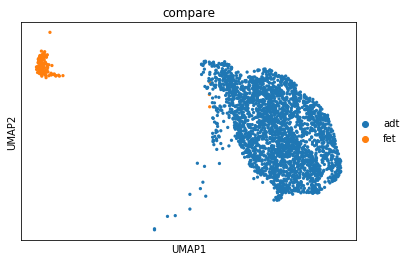

In [58]:
# fet cut vs adt cut
## exclude acral and foreskin location
input_adata = adata_subset2[[x not in ['acral','foreskin'] for x in adata_subset2.obs.general_location]]
input_adata.obs['compare'] = ['fet' if x == -1 else 'adt' for x in input_adata.obs.age]
sc.pl.umap(input_adata, color= ['compare'], cmap = 'magma_r')

## MannwhitneyU test with all genes
fet_cells = input_adata[input_adata.obs.compare == 'fet']
adt_cells = input_adata[input_adata.obs.compare == 'adt']

## Run test
gene_list = []
pval_list = []
stat_list = []
for idx, gene in enumerate(input_adata.var_names):
    fet_vec = fet_cells.X[:, idx]
#     print(fet_vec)
    adt_vec = adt_cells.X[:, idx]
#     print(adt_vec)
    try:
        stat, pval = stats.mannwhitneyu(fet_vec, adt_vec)
    except:
        stat = np.nan
        pval = np.nan
    stat_list.append(stat)
    pval_list.append(pval)
    gene_list.append(gene)

cut_df = pd.DataFrame({'gene':gene_list,
                      'pval':pval_list,
                      'stat':stat_list})





,gene,pval,stat,pass
2736,FBLN1,1.459883e-306,55548.5,True
3760,IGFBP3,2.151508e-243,19927.0,True
8121,SERPINF1,1.208277e-193,1505.0,True
2270,DUSP1,1.491473e-146,40416.0,True
5562,MEG3,1.555532e-137,110514.0,True
1944,CYR61,2.980078e-136,102858.0,True
1682,COL1A2,3.985787e-134,32535.0,True
6686,PAMR1,7.279559e-132,92145.5,True
6305,NGFR,2.182249e-130,117031.5,True
5515,MCHR1,1.394329e-125,37756.5,True


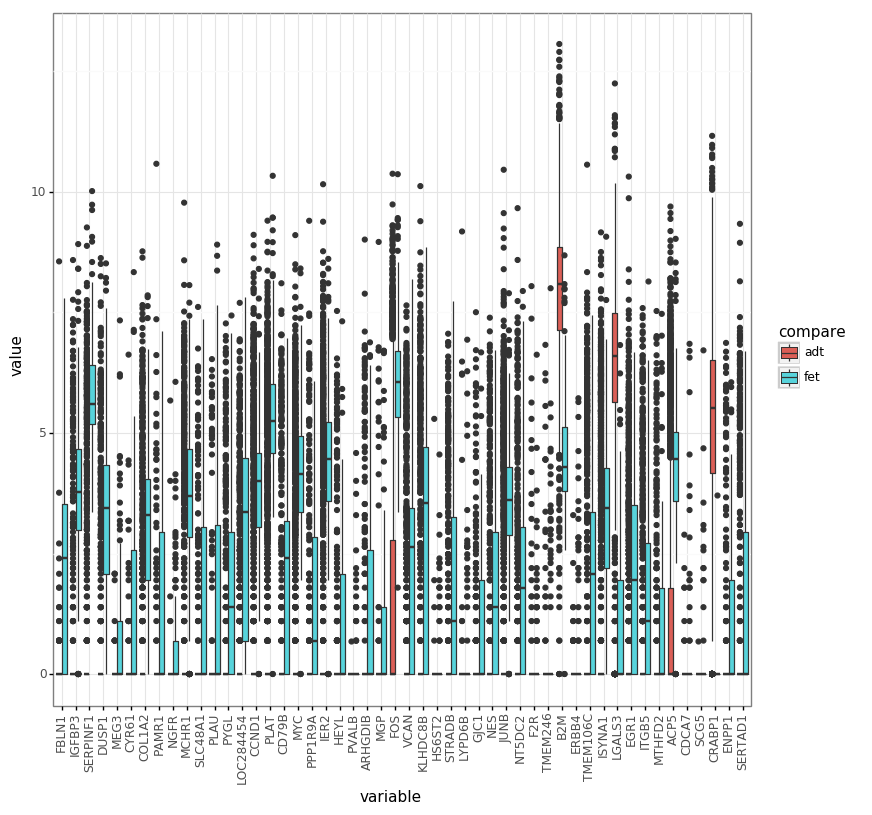

<ggplot: (8743391396216)>


In [60]:
# boxplots of expression levels
alpha = 0.001
cut_df['pass'] = [x < (alpha / len(input_adata.var_names.tolist())) for x in cut_df.pval]
cut_df = cut_df.sort_values('pval', ascending=True)
top_cut = cut_df.head(50) # look at top genes
display(top_cut)
cat, exp_df = prepare_dataframe(input_adata,
                          var_names = top_cut.gene.tolist(),
                          groupby = 'compare')
exp_df = exp_df.reset_index()
exp_df = pd.melt(exp_df, id_vars = 'compare')
exp_df['variable'] = exp_df['variable'].astype(str).astype(CategoricalDtype(top_cut.gene.tolist(), ordered=True))

plotnine.options.figure_size = (9,9)
print(ggplot(exp_df)
     +theme_bw() 
     +theme(axis_text_x = element_text(angle = 90))
     +geom_boxplot(aes('variable', 'value', fill = 'compare')))


# DEV

In [10]:
# cluster on fsk

%%capture

# cluster with 2 acral samples + 1 fskin
patientOIs = ['12WKM01', 'A1038LM', 'FS030_LM', 'FS043_LM']

input_adata = adata_subset2
patients = list(set(input_adata.obs.patient))
type_dict = {'in':patientOIs,
             'out':[x for x in patients if x not in patientOIs]}

classify_type(raw_adata, input_adata, 'patient', type_dict, 'class_4')

feature_dict = {'class_4':['in']}
adata_subset4 = subset_adata_v3(raw_adata,feature_dict)
adata_subset4 = process_adata(adata_subset4)
pca_adata(adata_subset4, num_pcs=30)
umap_adata(adata_subset4, res=0.15)


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_3' as categorical
... storing 'class_4' as categorical


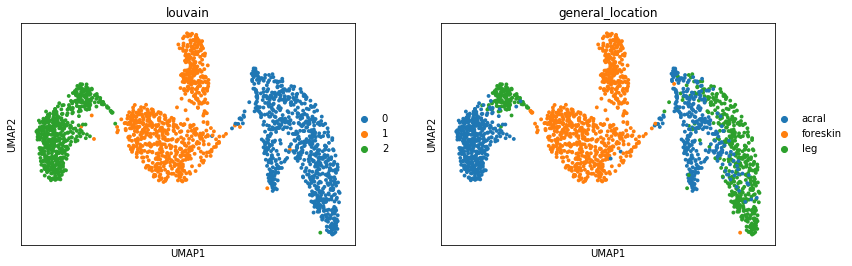

In [11]:
# DE gene tests
sc.pl.umap(adata_subset4, color=['louvain','general_location'])
ranks_df = simple_rank (adata_subset4, groupby='louvain', n_genes=10)
foreskin_test_genes = pd.merge(ranks_df[ranks_df.method == 'wilcoxon'].reset_index().rename(columns = {'index':'w'}).loc[:,['w','1']], 
         ranks_df[ranks_df.method == 't-test_overestim_var'].reset_index().rename(columns = {'index':'t'}).loc[:,['t','1']],
         'inner',
         '1').loc[:,'1'].values.tolist()

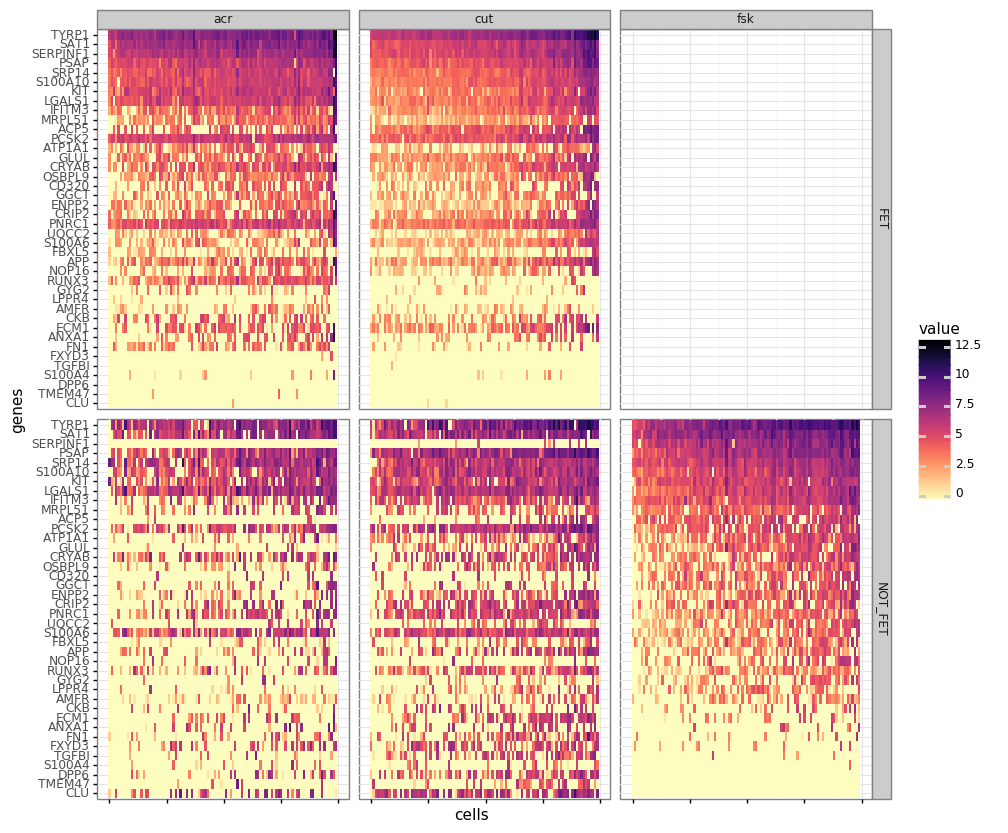

<ggplot: (-9223363253595040638)>


In [12]:
# heat map of foreskin vs rest
input_adata = adata_subset2
subsampled_patients = []
canonical_genes = ['PMEL','MLANA','DCT','TYR','MITF','KIT','SOX10'] # ref all MEL lit
groupby_var = 'fsk'
cell_groups = 'cell_type'
pcOIs = [2,3]
pc_genes = (pca_genes_df[[x == groupby_var and y in pcOIs for x,y in zip(pca_genes_df['groupby'], 
                                                                         pca_genes_df['pc_idx'])]]
                 .genes
                 .values
                 .tolist())
genelist_df = pd.DataFrame({'genes':pc_genes})
genelist = genelist_df.drop_duplicates().genes.values.tolist()

return_df = pd.DataFrame()
for label in list(set(input_adata.obs[cell_groups])): # cell types
    for group in list(set(input_adata.obs.age_label)):
        try:
            slice_df = input_adata[[x == label and y == group for x,y in zip(input_adata.obs[cell_groups], 
                                                                             input_adata.obs.age_label)]]
            cells2keep = slice_df.obs.sample(100).index.tolist()
            slice_df = slice_df[[x in cells2keep for x in slice_df.obs.index.tolist()]]
            cat, genesOI_df = prepare_dataframe(slice_df,
                                                var_names = genelist,
                                                groupby='age_label')  
            genesOI_df = genesOI_df.reset_index() # recover groupby label
            genesOI_df[cell_groups] = label
            genesOI_df['row_mean'] = genesOI_df.mean(axis = 1)
            genesOI_df = genesOI_df.sort_values('row_mean')
            genesOI_df['index'] = [x for x in range(len(genesOI_df))]
            return_df = return_df.append(genesOI_df.drop('row_mean', axis = 1))
        except:
            pass

plot_df = pd.melt(return_df, id_vars=['index','age_label',cell_groups])
target_gene_order = (plot_df[plot_df[cell_groups] == groupby_var]
                     .groupby('variable')
                     .mean()
                     .sort_values('value')
                     .index
                     .tolist())
plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(target_gene_order, ordered=True))

plotnine.options.figure_size = (10,10)
print(ggplot(plot_df)
      +theme_bw()
      +theme(panel_spacing = 0.1,
            axis_text_x = element_blank())
     +geom_tile(aes('index','variable',fill='value'))
     +scale_fill_cmap('magma_r')
     +facet_grid(f'age_label~{cell_groups}', scales='free')
     +labs(x='cells',y='genes'))

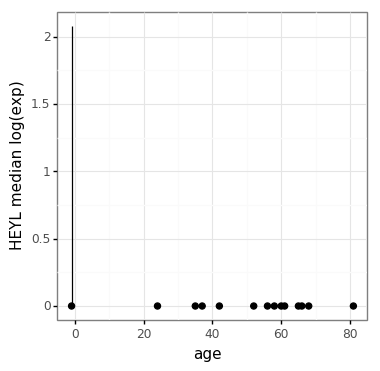

<ggplot: (8783258548905)>


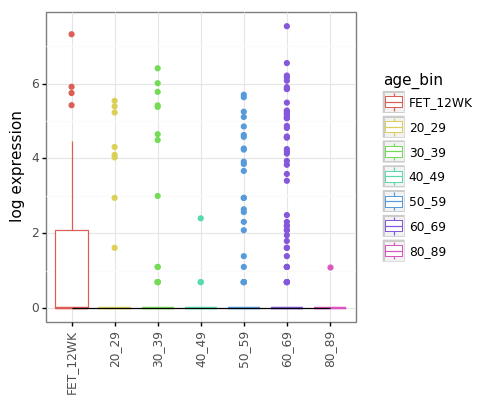

<ggplot: (-9223363253605179816)>


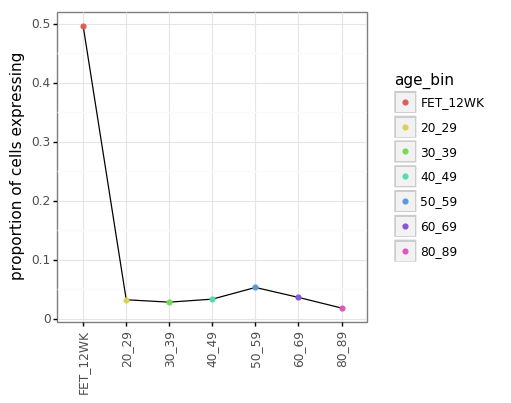

<ggplot: (8783249523190)>


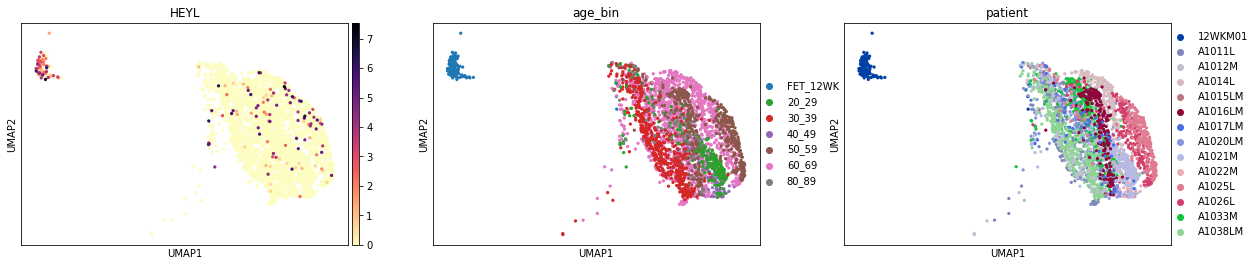

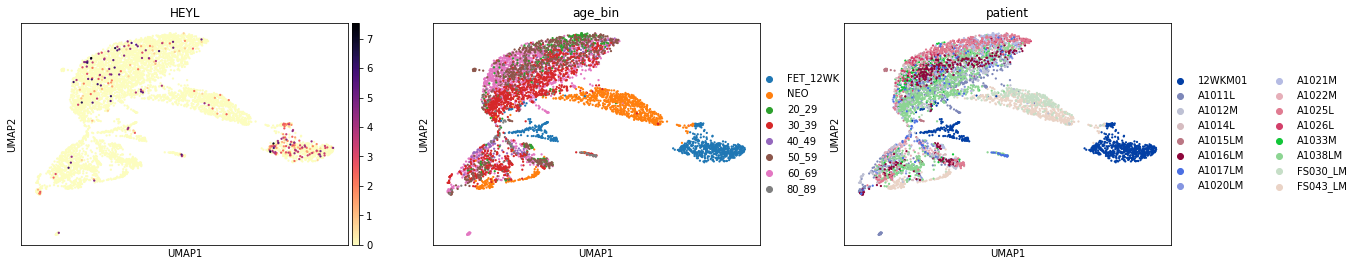

querying 1-1...done.
Finished.
0:  HEYL 
 This gene encodes a member of the hairy and enhancer of split-related (HESR) family of basic helix-loop-helix (bHLH)-type transcription factors. The sequence of the encoded protein contains a conserved bHLH and orange domain, but its YRPW motif has diverged from other HESR family members. It is thought to be an effector of Notch signaling and a regulator of cell fate decisions. Alternatively spliced transcript variants have been found, but their biological validity has not been determined. [provided by RefSeq, Jul 2008].


In [103]:
###############################################
###############################################
# Single-gene expression statistics
# Returns single-gene expression statistics as a function of true age
###############################################
###############################################

# Specify gene symbol
gene = 'HEYL'

# Specify age-binning: 'age_group' = 30-yr bins, 'age_bin' = 10-yr bins
groupby='age_bin'

###############################################

# true age
true_age_exp(gene, input_adata)

# binned age
gene2plots(input_adata, gene, groupby)
sc.pl.umap(input_adata, color=[gene, groupby, 'patient'], cmap='magma_r')
sc.pl.umap(full_adata, color=[gene, groupby, 'patient'], cmap='magma_r')

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]